<a href="https://colab.research.google.com/github/graphtrek/stockforecast/blob/main/graphtrek_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [182]:
#from google.colab import drive
#drive.mount('/content/drive')

In [183]:
# Test
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import requests
import json
import os, time

from plotly.subplots import make_subplots
from datetime import datetime, timedelta
from keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow import keras
tf.__version__

'2.6.0'

In [184]:
ticker = "V"
look_back = 5 # 5 days
all_data_size = 730 # 2 years
split_percent = 0.90 # use 90 of the data  for train
zoom = 180 # last 180 days see in chart
stock_api_response = pd.read_json('https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol='+ticker+'&outputsize=full&apikey=3F4URDEKOPLFH25T')

In [185]:
from google.colab import auth
auth.authenticate_user()

import gspread
from oauth2client.client import GoogleCredentials

gc = gspread.authorize(GoogleCredentials.get_application_default())

worksheet = gc.open('Stock Portfolio')
rows = worksheet.get_worksheet(3).get_all_values()
print(rows)



# Convert to a DataFrame and render.
import pandas as pd
stocks_df = pd.DataFrame.from_records(rows)
try :
  nr_of_shares = stocks_df.loc[stocks_df[1] == ticker][8].values[0]
  all_costs = stocks_df.loc[stocks_df[1] == ticker][9].values[0]
  cost_per_share = stocks_df.loc[stocks_df[1] == ticker][10].values[0]
except:
  nr_of_shares = 0
  all_costs = 0
  cost_per_share = 0
  
print('Shares:', nr_of_shares,'Cost:',all_costs,'Cost Per Share:',cost_per_share)

[['Investment Category', 'Stock Ticker', 'Google Price', 'Manual Price', 'Last Price', 'Last DPS', 'Yield on Cost', 'Last Price Yield', 'Shares', 'Cost', 'Cost (Per Share)', 'Unrealized Gain/Loss', 'Unrealized Gain/Loss (%)', 'Realized Gain/Loss', 'Dividends Collected', 'Total Gain/Loss', 'Mkt Value'], ['Dividend', 'HOG', '37.66', '0.000', '37.66', '0.000', '0.00%', '0.00%', '10.0', '$397.90', '$39.79', '-$21.30', '-5.4%', '$0.00', '$0.00', '-$21.30', '$376.60'], ['Dividend', 'LVS', '40.37', '0.000', '40.37', '0.000', '0.00%', '0.00%', '20.0', '$853.25', '$42.66', '-$45.85', '-5.4%', '$0.00', '$0.00', '-$45.85', '$807.40'], ['Dividend', 'CAT', '194.33', '0.000', '194.33', '0.000', '0.00%', '0.00%', '5.0', '$996.90', '$199.38', '-$25.25', '-2.5%', '$0.00', '$0.00', '-$25.25', '$971.65'], ['Dividend', 'DIS', '174.41', '0.000', '174.41', '0.000', '0.00%', '0.00%', '6.0', '$1,059.44', '$176.57', '-$12.98', '-1.2%', '$0.00', '$0.00', '-$12.98', '$1,046.46'], ['Dividend', 'CCL', '23.73', '0.

In [186]:
stock_api_data = stock_api_response['Time Series (Daily)']
#print(stock_api_data)
stock_api_data = stock_api_data.drop(index=['1. Information','2. Symbol','3. Last Refreshed','4. Output Size','5. Time Zone']);
#print(list(stock_api_data.items()))
data = []
for key, value in stock_api_data.items():
  data.append([
      pd.to_datetime(key,).date(),
      value.get('1. open'),
      value.get('2. high'),
      value.get('3. low'),
      value.get('5. adjusted close'),
      value.get('6. volume')
      ])

last_data =  str(data[0][0])
print(data[0])
data = np.flip(data[:all_data_size],axis=0)


[datetime.date(2021, 10, 14), '224.12', '225.65', '223.06', '225.18', '5563490']


In [187]:
model = None
model_file_path = '/content/drive/MyDrive/models/'+ticker+'.h5'
try:
  model = keras.models.load_model(model_file_path)
  modified = os.path.getmtime(model_file_path)

  print(data[0][0] - datetime.fromtimestamp(modified).date() )
  print('Loaded', ticker , 'model train date:',datetime.fromtimestamp(modified).date() , 'last data:', last_data)
except:
  model = None
  print('Model ' + ticker + ' does not exists.')

Model V does not exists.


In [188]:
df = pd.DataFrame(data,columns=['Date','Open','High','Low','Close','Volume'])

df['50MA'] = df['Close'].rolling(50).mean()
df['100MA'] = df['Close'].rolling(100).mean()
df['200MA'] = df['Close'].rolling(200).mean()

split = int(split_percent*len(data))

split

657

In [189]:
close_data = df['Close'].values
close_data = np.asarray(close_data).astype(np.float32)
close_data = close_data.reshape((-1))

train_data = close_data[:split]
test_data = close_data[split:]

train_dates = df['Date'][:split]
test_dates = df['Date'][split:]

volumes = np.asarray(df['Volume'].values).astype(np.int)
volume_dates = df['Date']
#len(test_data), test_data

In [190]:
trace1 = go.Scatter(
    x = train_dates,
    y = train_data,
    mode = 'lines',
    line=dict(width=3),
    name = 'Train'
)

trace2 = go.Scatter(
    x = test_dates,
    y = test_data,
    mode='lines',
    line=dict(width=3),
    name ='Test'
)

trace3 = go.Scatter(
    x = df['Date'],
    y = df['50MA'],
    mode='lines',
    name ='50MA'
)

trace4 = go.Scatter(
    x = df['Date'],
    y = df['100MA'],
    mode='lines',
    name ='100MA'
)

trace5 = go.Scatter(
    x = df['Date'],
    y = df['200MA'],
    mode='lines',
    name ='200MA'
)

layout = go.Layout(
    title = ticker + ' Date:' + last_data + ' Open:' + str(data[-1][1]) + ' High:' + str(data[-1][2]) + ' Low:' + str(data[-1][3]) + ' Close:' + str(data[-1][4]),
    xaxis = {'title' : "Dates"},
    yaxis = {'title' : "Close Price ($)"},
    height = 450
)
fig = go.Figure(data=[trace1, trace2, trace3, trace4, trace5], layout=layout)
fig.show()


fig = px.bar(x=volume_dates, y=volumes, height=250, labels={
                     "x": "Dates",
                     "y": "Volume"
                 },
                title=ticker)
fig.show()

In [191]:
# Normalizing data, scale between 0 and 1:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0, 1))
train_data_scaled = sc.fit_transform(train_data.reshape((-1,1)))
test_data_scaled = sc.fit_transform(test_data.reshape((-1,1)))
train_data_scaled.shape, test_data_scaled.shape

((657, 1), (73, 1))

Model V compiled.
Saved model V


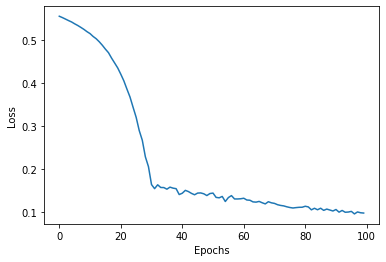

In [192]:
if model is None:
  # Building Model:
  # The LSTM layer expects the number of time steps and the number of features to work properly.
  model = tf.keras.models.Sequential()

  model.add(tf.keras.layers.LSTM(units=50, return_sequences=True, activation="relu",
                                input_shape=(look_back, 1)))

  model.add(tf.keras.layers.Dropout(0.2))

  model.add(tf.keras.layers.LSTM(units=50, return_sequences=True, activation="relu"))

  model.add(tf.keras.layers.Dropout(0.2))

  model.add(tf.keras.layers.LSTM(units=50, return_sequences=True, activation="relu"))

  model.add(tf.keras.layers.Dropout(0.2))

  model.add(tf.keras.layers.LSTM(units=50, activation="relu"))

  model.add(tf.keras.layers.Dropout(0.2))

  model.add(tf.keras.layers.Dense(units=1))

  model.compile(
      loss=tf.keras.losses.MAE,
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
      metrics=["mae"]
  )
  
  print('Model ' + ticker + ' compiled.')

  train_generator = TimeseriesGenerator(train_data_scaled, train_data_scaled, length=look_back)     
  
  modelo = model.fit(train_generator, epochs=100, verbose=0)
  model.save(model_file_path)
  print('Saved model ' + ticker)

  plt.plot(modelo.history['loss'])
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.show()

In [193]:
test_generator = TimeseriesGenerator(test_data_scaled, test_data_scaled, length=look_back)
predicted_stock_price_scaled = model.predict(test_generator)

In [194]:
predicted_stock_price = sc.inverse_transform(predicted_stock_price_scaled)
trace1 = go.Scatter(
    x = train_dates[zoom:],
    y = train_data[zoom:],
    mode = 'lines',
    name = 'Train'
)
trace2 = go.Scatter(
    x = test_dates,
    y = test_data,
    mode='lines',
    name = 'Test'
)
trace3 = go.Scatter(
    x = test_dates,
    y = predicted_stock_price.reshape((-1)),
    mode='lines',
    line=dict(width=3),
    name = 'Predict'
)
layout = go.Layout(
    title = ticker + ' Date:' + last_data + ' Open:' + str(data[-1][1]) + ' High:' + str(data[-1][2]) + ' Low:' + str(data[-1][3]) + ' Close:' + str(data[-1][4]),
    xaxis = {'title' : "Dates"},
    yaxis = {'title' : "Close Price ($)"},
    height = 600
)
fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
fig.show()
fig.write_html('/content/drive/MyDrive/models/'+ticker+ '_' + last_data + '_predict.html')

In [195]:
def predict(num_prediction, model):
    prediction_list = test_data_scaled[-look_back:]
    
    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        x = x.reshape((1, look_back, 1))
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[look_back-1:]
        
    return prediction_list
    
def predict_dates(num_prediction):
    last_date = df['Date'].values[-1]
    prediction_dates = pd.date_range(last_date, periods=num_prediction+1).tolist()
    return prediction_dates

num_prediction = look_back
forecast_scaled = predict(num_prediction, model)
forecast_dates = predict_dates(num_prediction)

forecast = sc.inverse_transform(forecast_scaled.reshape((-1,1)))
#forecast_dates,forecast

In [196]:
train_dates_size = len(train_dates)
train_data_size = len(train_data)
test_dates_size = len(test_dates)
test_data_size = len(test_data)
all_data_size = len(df['Open'].values[:])
print('train_dates_size:',train_dates_size,'train_data_size:',train_data_size,'test_dates_size:', test_dates_size, 'test_data_size:', test_data_size, 'all_data_size:',all_data_size)


trace1 = go.Candlestick(
    x = train_dates[train_dates_size-test_dates_size:],
    open = df['Open'].values[train_dates_size-test_dates_size:],
    high = df['High'].values[train_dates_size-test_dates_size:],
    low = df['Low'].values[train_dates_size-test_dates_size:],
    close = train_data[train_dates_size-test_dates_size:],
#    mode = 'lines',
#    line=dict(width=3),
    name = 'Train'
)
trace2 = go.Candlestick(
    x = test_dates,
    open = df['Open'].values[split:],
    high = df['High'].values[split:],
    low = df['Low'].values[split:],
    close = test_data,
#    y = test_data,
#    mode='lines',
    name = 'Test'
)

trace3 = go.Scatter(
    x = test_dates,
    y = predicted_stock_price.reshape((-1)),
    mode='lines',
    name = 'Predict'
)
trace4 = go.Scatter(
    x = forecast_dates,
    y = forecast.reshape((-1)),
    mode='lines',
    line=dict(width=3),
    name = 'Forecast'
)
trace5 = go.Scatter(
    x = df['Date'][train_dates_size-test_dates_size:],
    y = df['50MA'][train_dates_size-test_dates_size:],
    mode='lines',
    name ='50MA'
)
trace6 = go.Scatter(
    x = df['Date'][train_dates_size-test_dates_size:],
    y = df['100MA'][train_dates_size-test_dates_size:],
    mode='lines',
    name ='100MA'
)
trace7 = go.Scatter(
    x = df['Date'][train_dates_size-test_dates_size:],
    y = df['200MA'][train_dates_size-test_dates_size:],
    mode='lines',
    name ='200MA'
)


print('Shares:', nr_of_shares,'Cost:',all_costs,'Cost Per Share:', cost_per_share, '50MA:', int(df['50MA'].values[-1]))
print('Forecast:',forecast.reshape((-1)).astype(np.int))
layout = go.Layout(
    title = 
    '<b>'+ticker+ '</b>' + ' Date:' + last_data + '<BR>' 
    'Open:' + str(data[-1][1]) + 
    ' High:' + str(data[-1][2]) + 
    ' Low:' + str(data[-1][3]) + 
    ' Close:' + str(data[-1][4]) + 
    ' ' +
    'Forecast in ' + str(len(forecast_dates)) + ' days ' + str(np.around(forecast.mean())) + 
    '<BR>' + 
    'Shares:' + str(nr_of_shares) +
    ' Cost: ' + str(all_costs).replace('$','') +
    ' Cost Per Share: ' + str(cost_per_share).replace('$',''),
    xaxis = {'title' : 'Dates'},
    yaxis = {'title' : 'Close Price ($)'},
    height = 600,
    font=dict(
        family="Courier New, monospace",
        size=8,
        color="#7f7f7f"
    )
)


fig = go.Figure(data=[trace1, trace2, trace3, trace4, trace5, trace6, trace7], layout=layout)

fig.update_yaxes(showspikes=True, spikemode='across', spikesnap='cursor',spikedash='dash')
fig.update_xaxes(showspikes=True, spikemode='across', spikesnap='cursor', spikedash='dash')
fig.update_layout(xaxis_rangeslider_visible=False)



config = dict({'scrollZoom': True})
fig.show(config=config)

fig.write_html('/content/drive/MyDrive/models/'+ticker+ '_' + last_data + '_forecast.html')

fig = px.bar(x=volume_dates[train_dates_size-test_dates_size:], y=volumes[train_dates_size-test_dates_size:], height=250, labels={
                     "x": "Dates",
                     "y": "Volume"
                 },
                title=ticker)
fig.show()

train_dates_size: 657 train_data_size: 657 test_dates_size: 73 test_data_size: 73 all_data_size: 730
Shares: 5.0 Cost: $1,122.90 Cost Per Share: $224.58 50MA: 228
Forecast: [225 230 229 228 229 230]
